# Algorytmy macierzowe - zadanie nr 2 - Eliminacja Gaussa i LU Faktoryzacja dla macierzy gęstych

"Proszę wybrać język programowania wedle uznania
Proszę napisać procedurę [S]=Schur_Complement(A,n,m)
gdzie A to macierz wejściowa, n to rozmiar tej macierzy A,
m to rozmiar podmacierzy (tzw. dopełnienia Schura),
powstałej poprzez wyeliminowanie n-m wierszy i kolumn
z macierzy A, wykorzystując [zatrzymując po n-m krokach]:
 
6. Faktoryzacja Cholesky’ego “wektorową” (slajd 28) 
"

Marcin Hawryluk, Norbert Wolniak <br>grupa: piątek 12:50B <hr>

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.linalg as sp

Do implementacji wybraliśmy język Python 3 wraz z biblioteką do obliczeń numerycznych numpy, która pozwala operować na macierzach zaimplementowanych bezpośrednio w języku C.

## Generowanie macierzy

Macierze, których będziemy używać, wygenerowaliśmy za pomocą dostarczonej procedury massmatrix, napisanej w środowisku Octave. Macierze zapisaliśmy w postaci pliku tekstowego, a następnie odczytaliśmy w Pythonie za pomocą poniższej funkcji.

In [2]:
def read_matrix(file_name):
    with open(file_name, 'r') as file:
        for line in file:
            if line.strip() == '':
                continue
            if line[0] == '#':
                if line[2:6] == "rows":
                    _, _, size = line.split()
                    size = int(size)
                    matrix = np.zeros((size, size))
            else:
                row, col, val = line.split(' ')
                matrix[int(row)-1, int(col)-1] = val
            
    return matrix

In [119]:
matrix_small = read_matrix('matrices/riga_2.txt')

* przygotowanie zestawu macierzy do testów:

In [6]:
fem_matrices  = []
riga_matrices = []

for file in os.listdir('matrices'):
    if file.startswith('riga'):
        riga_matrices.append(read_matrix('matrices/' + file))
    if file.startswith('fem'):
        fem_matrices.append(read_matrix('matrices/' + file))

## Faktoryzacja Cholesky'ego i dopełnienie Schura 

wersja z wykładu:

In [7]:
def schur_complement(matrix,  m=0):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n-m):
        if abs(A[k, k]) < 1e-8:
            raise ValueError('singular matrix')
            
        vk = A[k+1:n, k]
        A[k, k] = A[k, k]**0.5
        dkk = A[k, k]
        A[k+1:n, k] /= dkk
        
        for j in range(k+1, n):
            A[j:n, j] -= A[j:n, k]*vk[j-k-1]
        
    return A

wersja z internetu:

In [8]:
def schur_complement2(matrix, m=0):
    S = matrix.copy()
    n = S.shape[0]
    L = np.zeros((n, n))
    
    for j in range(n-m):
        L[j, j] = S[j, j]**0.5
        L[j+1:n, j] = S[j+1:n, j]/L[j,j]
        
        for i in range(j+1, n):
            S[i, j+1:n] -= L[i, j]*L[j+1:n, j]
    
    
    return L

In [9]:
def schur_complement3(matrix, m=0):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n-m):
        if abs(A[k, k]) < 1e-8:
            raise ValueError('singular matrix')
            
        vk = A[k+1:n, k]
        A[k, k] = A[k, k]**0.5
        dkk = A[k, k]
        A[k+1:n, k] /= dkk
        
        for j in range(k+1, n):
            A[j, k+1:n] -= A[j, k]*vk
    
    return A

In [118]:
def schur_LDLT(matrix, m=0):
    A = matrix.copy()
    n = A.shape[0]
    
    for k in range(n - m - 1):
        dkk = A[k, k]
        if abs(dkk) < 1e-8:
            raise ValueError('singular matrix')

        vk = A[k+1:n, k].copy()
        A[k+1:n, k] /= dkk
      
        for j in range(k + 1, n):
            A[j:n, j] -= A[j:n, k] * vk[j - k - 1]
    
    return A[max(0,n-m-1):n, max(0,n-m-1):n]

In [106]:
m = np.array([[4, 4, 6], [4, 13, 15], [6, 15, 43]], dtype=float)

In [120]:
print(schur_complement(m, 0))
print(schur_complement2(m, 0))
print(schur_complement3(m, 0))
print(schur_LDLT(m, m.shape[0]))
print(np.linalg.cholesky(m))

[[ 2.  4.  6.]
 [ 2.  3. 15.]
 [ 3.  3.  5.]]
[[2. 0. 0.]
 [2. 3. 0.]
 [3. 3. 5.]]
[[2. 4. 6.]
 [2. 3. 9.]
 [3. 3. 5.]]
[[ 4.  4.  6.]
 [ 4. 13. 15.]
 [ 6. 15. 43.]]
[[2. 0. 0.]
 [2. 3. 0.]
 [3. 3. 5.]]


W celu weryfikacji poprawności powyższej funkcji, porównujemy wynik z faktoryzacją otrzymaną przy użyciu funkcji biblioteki numpy: 

In [171]:
def cholesky_test(A):
    return np.allclose(schur_complement2(A, 0), np.linalg.cholesky(A))

In [172]:
cholesky_test(matrix_small)

True

### Pomiar czasów

"(...) proszę narysować następujący wykres: <br>
> oś pozioma: rozmiar macierzy n dla liczby przedziałów nxx=2,3,4,… (tak duże macierze ile się uda policzyć na laptopie), <br>
oś pionowa: czas [s] (Octave tic; Schur Complement(...); toc)  

Proszę narysować 

> a) wykres czasu obliczeń dopełnień Schura o rozmiarze n/2
 ** b) wykres czasu obliczeń dopełnień Schura o rozmiarze n/4
 ** c) … takie podziały jakie mają sens do rozmiaru 1"

In [173]:
def compare_times(matrices):
    times = {}
    
    for matrix in matrices:
        n = matrix.shape[0]
        times[n] = {}
        
        start = time()
        schur_complement2(matrix, n//2)
        times[n]['n/2'] = time() - start
        
        start = time()
        schur_complement2(matrix, n//4)
        times[n]['n/4'] = time() - start
        
        start = time()
        schur_complement2(matrix, 1)
        times[n]['1'] = time() - start
        
    df = pd.DataFrame(times).T.sort_index()
    df.plot(
        figsize=(13, 10),
        xlabel='matrix size (n x n)',
        ylabel='time [s]',
        colormap='Accent',
        linewidth=3,
        markersize=10,
        marker='o'
    )
        
    
    return df

* dla macierzy IGA riga=0, pxx=2, rxx=0

,n/2,n/4,1
16,0.000461,0.000704,0.000686
25,0.001032,0.001413,0.001711
36,0.001940,0.002342,0.002484
49,0.004544,0.004982,0.005149
64,0.006265,0.008974,0.008441
81,0.011088,0.013312,0.014287
100,0.030317,0.043494,0.026888
121,0.031001,0.028356,0.029466
144,0.032587,0.039900,0.041180


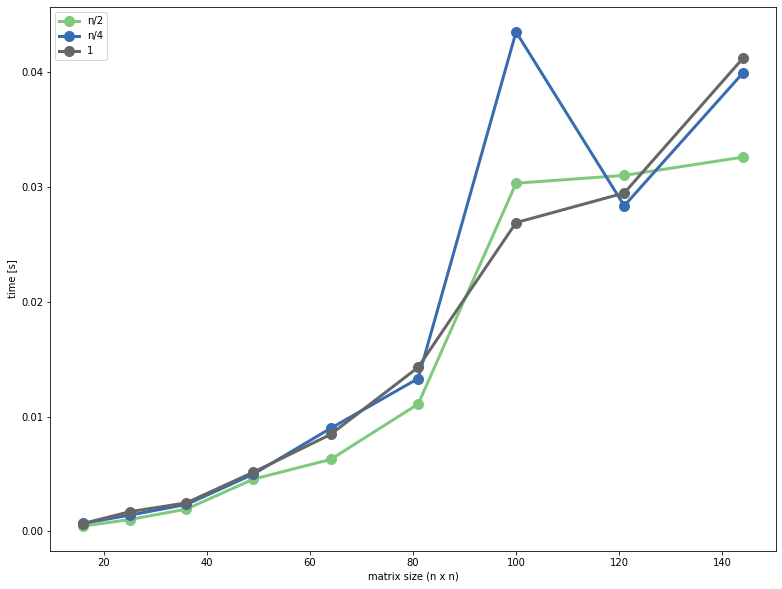

In [174]:
compare_times(riga_matrices)

* dla macierzy FEM riga=1, pxx=2, rxx=0

,n/2,n/4,1
25,0.002977,0.001911,0.001852
49,0.008578,0.007377,0.006438
81,0.009888,0.012708,0.013121
121,0.023529,0.027348,0.037074
169,0.046116,0.056574,0.060564
225,0.116963,0.114950,0.120441
289,0.142296,0.171750,0.267048
361,0.288895,0.367838,0.366767
441,0.351674,0.431281,0.453224
529,0.529567,0.634555,0.679491


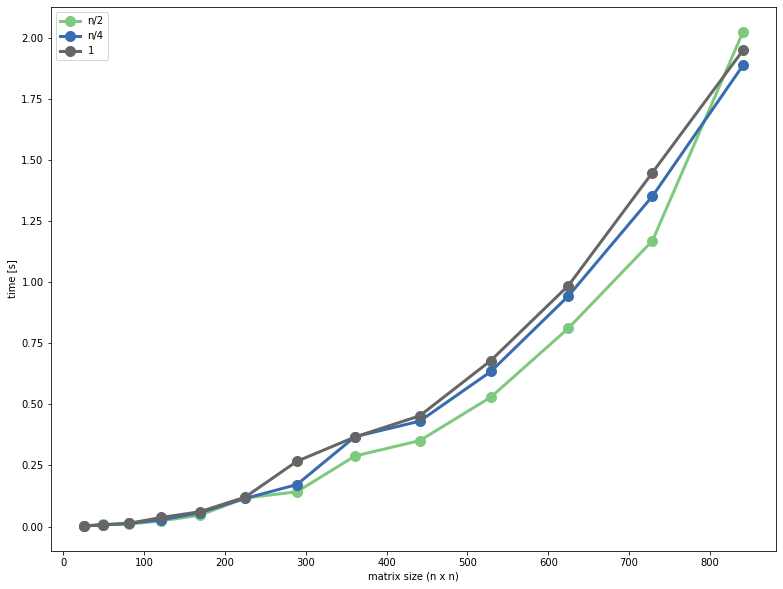

In [175]:
compare_times(fem_matrices)

## Koszt obliczeniowy i pamięciowy

"3. Jaki jest koszt obliczeniowy i pamięciowy (flopsy i memopsy) zaimplementowanego
algorytmu?"

Koszt obliczeniowy (flops): <br>
$$ \sum \limits _{k=0} ^{n-1} [(n-k-1) + \sum \limits _{j=k+1} ^{n} (n-j)*2]$$ <br>
$$ \sum \limits _{k=0} ^{n-1} [(n-k-1) + (k-n)*(1+k-n)]$$ <br>
$$ \frac{1}{3}n^3 +\frac{1}{2}n^2 -\frac{5}{6}n $$ <br>
Koszt pamięciowy (memops): <br>
$$ \sum \limits _{k=0} ^{n-1} [3 + 4*(n-k-1) + \sum \limits _{j=k+1} ^{n} 1 + 2*(n-j)] $$ <br>
$$ \sum \limits _{k=0} ^{n-1} [3 + 4*(n-k-1) + (k - n)^2] $$ <br>
$$ \sum \limits _{k=0} ^{n-1} [3 + 4*(n-k-1) + (k - n)^2] $$ <br>
$$ \frac{1}{3}n^3 + \frac{15}{6}n^2 + \frac{7}{6}n $$ <br>

## Wnioski

* Algorytm faktoryzacji LDL^T ma porównywalne koszty obliczeniowe i pamięciowe.
* 

M. Hawryluk, N. Wolniak. 2021